In [16]:
import numpy as np
import pandas as pd
import scipy.io
from sklearn.tree import DecisionTreeClassifier as dtc
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
import scipy
import scipy.io as sio
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm_notebook 
from sklearn.metrics import accuracy_score


In [17]:
#Load Labels
hyp01 = scipy.io.loadmat('SC4001E0-PSG_hyp')
hyp11 = scipy.io.loadmat('SC4011E0-PSG_hyp')
hyp12 = scipy.io.loadmat('SC4012E0-PSG_hyp')
hyp21 = scipy.io.loadmat('SC4021E0-PSG_hyp')
hyp22 = scipy.io.loadmat('SC4022E0-PSG_hyp')
hyp31 = scipy.io.loadmat('SC4031E0-PSG_hyp')
hyp32 = scipy.io.loadmat('SC4032E0-PSG_hyp')
hyp41 = scipy.io.loadmat('SC4041E0-PSG_hyp')
hyp42 = scipy.io.loadmat('SC4042E0-PSG_hyp')
hyp51 = scipy.io.loadmat('SC4051E0-PSG_hyp')

hyp01 = hyp01['hypnogram'][799:1633]
hyp11 = hyp11['hypnogram'][799:1633]
hyp12 = hyp12['hypnogram'][799:1633]
hyp21 = hyp21['hypnogram'][799:1633]
hyp22 = hyp22['hypnogram'][799:1633]
hyp31 = hyp31['hypnogram'][799:1633]
hyp32 = hyp32['hypnogram'][799:1633]
hyp41 = hyp41['hypnogram'][799:1633]
hyp42 = hyp42['hypnogram'][799:1633]
hyp51 = hyp51['hypnogram'][799:1633]

hypt = np.concatenate((hyp01, hyp11, hyp12, hyp21, hyp22, hyp31, hyp32, hyp41, hyp42, hyp51), axis = 0)

###Load in features
data1 = scipy.io.loadmat('features(10)_cwt.mat')['features']

data01 = data1[(799):(1633),:]
data02 = data1[(799+((1)*1633)):(1633+((1)*1633)),:]
data03 = data1[(799+(2)*1633):(1633+(2)*1633),:]
data04 = data1[(799+(3)*1633):(1633+(3)*1633),:]
data05 = data1[(799+(4)*1633):(1633+(4)*1633),:]
data06 = data1[(799+(5)*1633):(1633+(5)*1633),:]
data07 = data1[(799+(6)*1633):(1633+(6)*1633),:]
data08 = data1[(799+(7)*1633):(1633+(7)*1633),:]
data09 = data1[(799+(8)*1633):(1633+(8)*1633),:]
data10 = data1[(799+(9)*1633):(1633+(9)*1633),:]

data = np.concatenate((data01, data02, data03, data04, data05, data06, data07, data08, data09, data10), axis = 0)
m, n = hypt.shape

for i in range(m):
    if hypt[i,1]==4:
        hypt[i,1]=3
    elif hypt[i,1]==6:
        hypt[i,1]=0

data = (data-np.mean(data,axis=0))/np.std(data,axis=0)

### Random Forest

In [18]:

class Random_Forest():

    def __init__(self , data , labels):
        self.data = data
        self.labels = labels
        self.data_labels = np.concatenate((data,labels.reshape([-1,1])), axis = 1)
        self.all_trees = []
        self.track_features = []

        

    def bootstrap(self):
        number_of_samples = self.data_labels.shape[(0)]
        bootstrapped_idx = np.random.randint(number_of_samples-1, size = (number_of_samples))
        bootstrapped_data = []
        for i in (bootstrapped_idx):

            bootstrapped_data.append(self.data_labels[i])
    
        return bootstrapped_data
    
    def random_forest_classification(self, num_of_trees): # labels = hypt , data = data
        total_num_of_features = self.data.shape[(1)]
   
        features = int(np.floor(np.sqrt(total_num_of_features)))
        
        
        for i in range(num_of_trees):
            bootstrapped_data = self.bootstrap()
            random_indices = np.random.randint(0,total_num_of_features,size = (features))
            self.track_features.append(random_indices.tolist())
            bootstrapped_data = np.array(bootstrapped_data)
            bootstrapped_data_data = bootstrapped_data[:,:-1]
            random_feature_selection = bootstrapped_data_data[: , random_indices] 

            single_tree = dtc()
            single_tree.fit(random_feature_selection,bootstrapped_data[:,-1])
            self.all_trees.append(single_tree)

            #Data_for_tree = np.concatenate((self.data,self.labels.reshape([-1,1])), axis = 1)
        #print(self.track_features)    
        return self.all_trees

    def random_forest_predict(self, test_data):
        predictions = []
        results = []
        for i,j in zip(self.all_trees,self.track_features):
            predictions.append((i.predict(test_data[:,j])).tolist())
        #print(predictions[1])

        predictions = np.array(predictions)
        predictions = predictions.astype("int64")
        for i in range(np.shape(predictions)[1]):
            results.append(np.argmax(np.bincount(predictions[:,i])))

        return results

In [19]:
x_train , x_test , y_train , y_test = train_test_split(data,hypt[:,1], test_size=0.1)
rf = Random_Forest(x_train,y_train)
data1 = (rf.random_forest_classification(40))
pred = rf.random_forest_predict(x_test)
print("Accuracy is ",(y_test == pred).sum()/len(y_test)*100,"%")
aa = pd.crosstab(np.array(y_test), np.array(pred), rownames = ['Actual'], colnames = ['Predicted'])
aa

Accuracy is  74.70023980815348 %


Predicted,0,1,2,3,5
Actual,,,,,
0,147,1,4,0,1
1,14,12,38,0,7
2,2,5,354,8,15
3,0,0,47,68,0
5,4,5,60,0,42


### KNN

In [20]:
class K_Nearest_Neighbors:

    def __init__(self, K):
        self.K = K
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def knn_predict(self, X_test):
        Result = [] 
        for i in range(len(X_test)):
            distances = [] 
            classifiers = [] 
            for j in range(len(self.X_train)):
                dist = scipy.spatial.distance.euclidean(self.X_train[j] ,X_test[i]) 
                distances.append([dist, j])
            distances.sort() 
            distances = distances[0:self.K] 
            for distances, j in distances:
                classifiers.append(y_train[j])
                
            temp = Counter(classifiers).most_common(1)[0][0] 
            Result.append(temp)
            
        return Result

In [21]:
KNN = K_Nearest_Neighbors(17)
KNN.fit(x_train,y_train)
y_pred = KNN.knn_predict(x_test)
print("Accuracy is ",(y_test == y_pred).sum()/len(y_test)*100,"%")
aa = pd.crosstab(np.array(y_test), np.array(pred), rownames = ['Actual'], colnames = ['Predicted'])
aa

Accuracy is  81.65467625899281 %


Predicted,0,1,2,3,5
Actual,,,,,
0,147,1,4,0,1
1,14,12,38,0,7
2,2,5,354,8,15
3,0,0,47,68,0
5,4,5,60,0,42


### SVM

In [7]:
def train_svm(x,y,lr,lambd,epochs = 100): #lambd = 1/nC
    n = x.shape[0]
   
    w = np.zeros([len(x[0]),1])
    loss_ar = []
    b = 0
    acc_ar = []
    acc_ar.append(0)
    for epoch in range(epochs):
        dw = np.zeros(w.shape)
      
        z = np.maximum(0,1-y*(np.dot(x,w)+b))
        loss = np.sum(z) + lambd*np.sum(w*w)/2
        loss_ar.append(loss)
        dw = lambd*w - 1/n *(np.sum((x*y),axis = 0).reshape(-1,1))
        q = x*y
        for i in range(n):
            if(z[i] == 0):
                q[i][:] = 0
        dw = lambd*w - (np.sum(q,axis = 0).reshape(-1,1))/n
        w = w - lr * dw
        acc = predict(w,b,x,y)
        acc_ar.append(acc)
        b = lr*np.sum(y - np.dot(x,w))/n
        if(loss<1):
            print("epoch {}, loss = {}, accuaracy = {}.\nTerminating due to reaching threshold of loss < 1".format(epoch+1,loss,acc))
            return w,b,loss_ar,acc_ar
        if(acc>99):
            print("epoch {}, loss = {}, accuaracy = {}.\nTerminating due to reaching threshold of train accuracy > 99".format(epoch+1,loss,acc))
            return w,b,loss_ar,acc_ar
        if(not epoch):
            print("epoch {}, loss = {}, accuaracy = {}.".format(epoch,loss,acc))
        elif(epoch <101):
            if(epoch%99 == 0):
                print("epoch {}, loss = {}, accuaracy = {}.".format(epoch+1,loss,acc))
        elif(epoch%499 ==0):
            print("epoch {}, loss = {}, accuaracy = {}.".format(epoch+1,loss,acc))
        
    return w,b,loss_ar,acc_ar

def predict(w,b,x,y):
    pred = np.dot(x,w)+b
    n = x.shape[0]
    pred[pred>0] = 1
    pred[pred<0] = -1
    t = np.sum(pred == y)
    #print(x.shape,y.shape)
    acc = t/n
    return acc*100

def train_multi_svm(train_set,test_set,y_train,y_test):
    accuracy = []
    arr = len(np.unique(y_test))
    loss_t = []
    parameters = {}
    print("Found {} unique labels. Training {} Support vector machines".format(arr,arr))
    for i in range(len(np.unique(y_test))):         
        y = y_train.copy()
        
        y[y != i] = -1
        y[y == i] = 1
        y = y.reshape(-1,1)
        print(y.shape)
        #print("test",np.unique(y))
        yt = y_test.copy()    
        yt[yt != i] = -1
        yt[yt == i] = 1
        #print("test",np.unique(yt))
        yt = yt.reshape(-1,1)
        print("training SVM {} of 5".format(i+1))
        w,b,loss,acc = train_svm(train_set,y,0.01,0.1,1000)  
        print("Test set accuracy = {}".format(predict(w,b,test_set,yt)))
        parameters[i] = {}
        parameters[i]["accuracy"] = acc
        parameters[i]["test_accuracy"] = predict(w,b,test_set,yt)
        parameters[i]["loss"] = loss
        parameters[i]["w"] = w
        parameters[i]["b"] = b
    return parameters

In [8]:
parametres = train_multi_svm(x_train,x_test,y_train,y_test)

Found 5 unique labels. Training 5 Support vector machines
(7506, 1)
training SVM 1 of 5
epoch 0, loss = 7506.0, accuaracy = 75.59285904609646.
epoch 100, loss = 4713.70265833951, accuaracy = 76.60538236077804.
epoch 500, loss = 3937.2353793901243, accuaracy = 80.10924593658406.
epoch 999, loss = 3662.908099940728, accuaracy = 81.65467625899281.
Test set accuracy = 80.69544364508393
(7506, 1)
training SVM 2 of 5
epoch 0, loss = 7506.0, accuaracy = 59.379163335997866.
epoch 100, loss = 6957.31510031816, accuaracy = 59.96536104449773.
epoch 500, loss = 6832.323303590533, accuaracy = 59.79216626698641.
epoch 999, loss = 6824.510689916732, accuaracy = 59.63229416466827.
Test set accuracy = 59.47242206235012
(7506, 1)
training SVM 3 of 5
epoch 0, loss = 7506.0, accuaracy = 72.95496935784705.
epoch 100, loss = 5963.605544246362, accuaracy = 73.40794031441513.
epoch 500, loss = 5238.873648717531, accuaracy = 72.44870770050626.
epoch 999, loss = 5049.511008912695, accuaracy = 73.26139088729016.

### Multilayer Perceptron

In [9]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

<ipython-input-9-c9483c962252>:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/1500 [00:00<?, ?epoch/s]

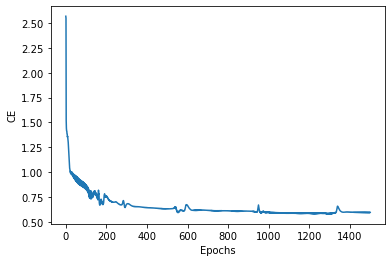

Validation accuracy 0.67


In [10]:
enc = OneHotEncoder()
y_OH_train = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_OH_test = enc.fit_transform(np.expand_dims(y_test,1)).toarray()
ffsn_multi = FFSN_MultiClass(7,5,[4,4])
ffsn_multi.fit(x_train,y_OH_train,epochs=1500,learning_rate=.006,display_loss=True)


Y_pred_train = ffsn_multi.predict(x_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ffsn_multi.predict(x_test)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, y_train)
accuracy_val = accuracy_score(Y_pred_val, y_test)

print("Validation accuracy", round(accuracy_val, 2))